In [1]:
import os
import pickle
import warnings
import dateutil.parser as parser
import io

# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path+"\\src")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

In [2]:
from EDA_utils import avg_time_tg
avg_time_tg()

,Источник,Минимальное время,Среднее время,Максимальное время
0,ak47pfl_raw,0.0,234.338346,39334.366667
1,antiskrepa_raw,0.0,233.018314,12765.733333
2,banksta_raw,0.0,87.166368,6875.916667
3,bitkogan_raw,0.0,151.439083,4153.933333
4,cbonds_raw,0.0,233.968676,17395.250000
5,cbrstocks_raw,0.0,41.110203,31780.200000
6,divForever_raw,0.0,168.131328,430861.250000
7,DividendNews100_raw,0.0,373.240590,10593.516667
8,economika_raw,0.0,147.148396,16881.366667
9,economylive_raw,NaN,NaN,NaN


### Граф связей Телеграмм каналов

In [22]:
files = os.listdir('Telegram prep')
files = [f for f in files if f[0]!='.']
files.remove('messages')
channel_lst = [ch[:-4] for ch in files]
id_lst = ['1203560567', '1101170442', '1421472880', '1453563350', '1441563903',
         '1138794914', '1425338344', '1197210433', '1101154601', '1218872940',
         '1366793743', '1050451805', '1468147635', '1063908560', '1036362176',
          '1097119425', '1066174394', '1061574166', '1445969592', '1595965216', '1152653774', '1408960847',
          '1107922757', '1132713042', '1428717522', '1121232878', '1136626166', '1054426741', '1191785705',
           '1141631276', '1099860397', '1075101206', '1006112008', '1199979298']
channel_id_dct = {i:j for i,j in zip(channel_lst, id_lst)}
channel_name_dct = {int(j):i for i,j in channel_id_dct.items()} 

In [3]:
edges = []
for file, channel in zip(files, channel_lst):
    df = pd.read_csv(f'Telegram prep/{file}', low_memory=False)
    df = df[df['fwd_from'].notna()].reset_index(drop=True)
    for idx, row in df.iterrows():
        fwd_from = eval(row['fwd_from'])['from_id']
        if fwd_from is not None and 'channel_id' in fwd_from:
            fwd = fwd_from['channel_id']
            # edges.append([channel, fwd])
            edges.append([int(channel_id_dct[channel]), fwd])

In [26]:
unique, counts = np.unique(edges, return_counts=True)
edges_filtered = unique[counts > 50]

bool_array = []
for edge in edges:
    if (edge[0] in edges_filtered) and (edge[1] in edges_filtered) and (edge[0] in channel_name_dct) and (edge[1] in channel_name_dct):
        bool_array.append(True)
    else:
        bool_array.append(False)

edges_fil = np.array(edges)[bool_array]

In [30]:
edges_fil = np.vectorize(channel_name_dct.get)(edges_fil)

In [32]:
g = nx.DiGraph()
g.add_edges_from(edges_fil)

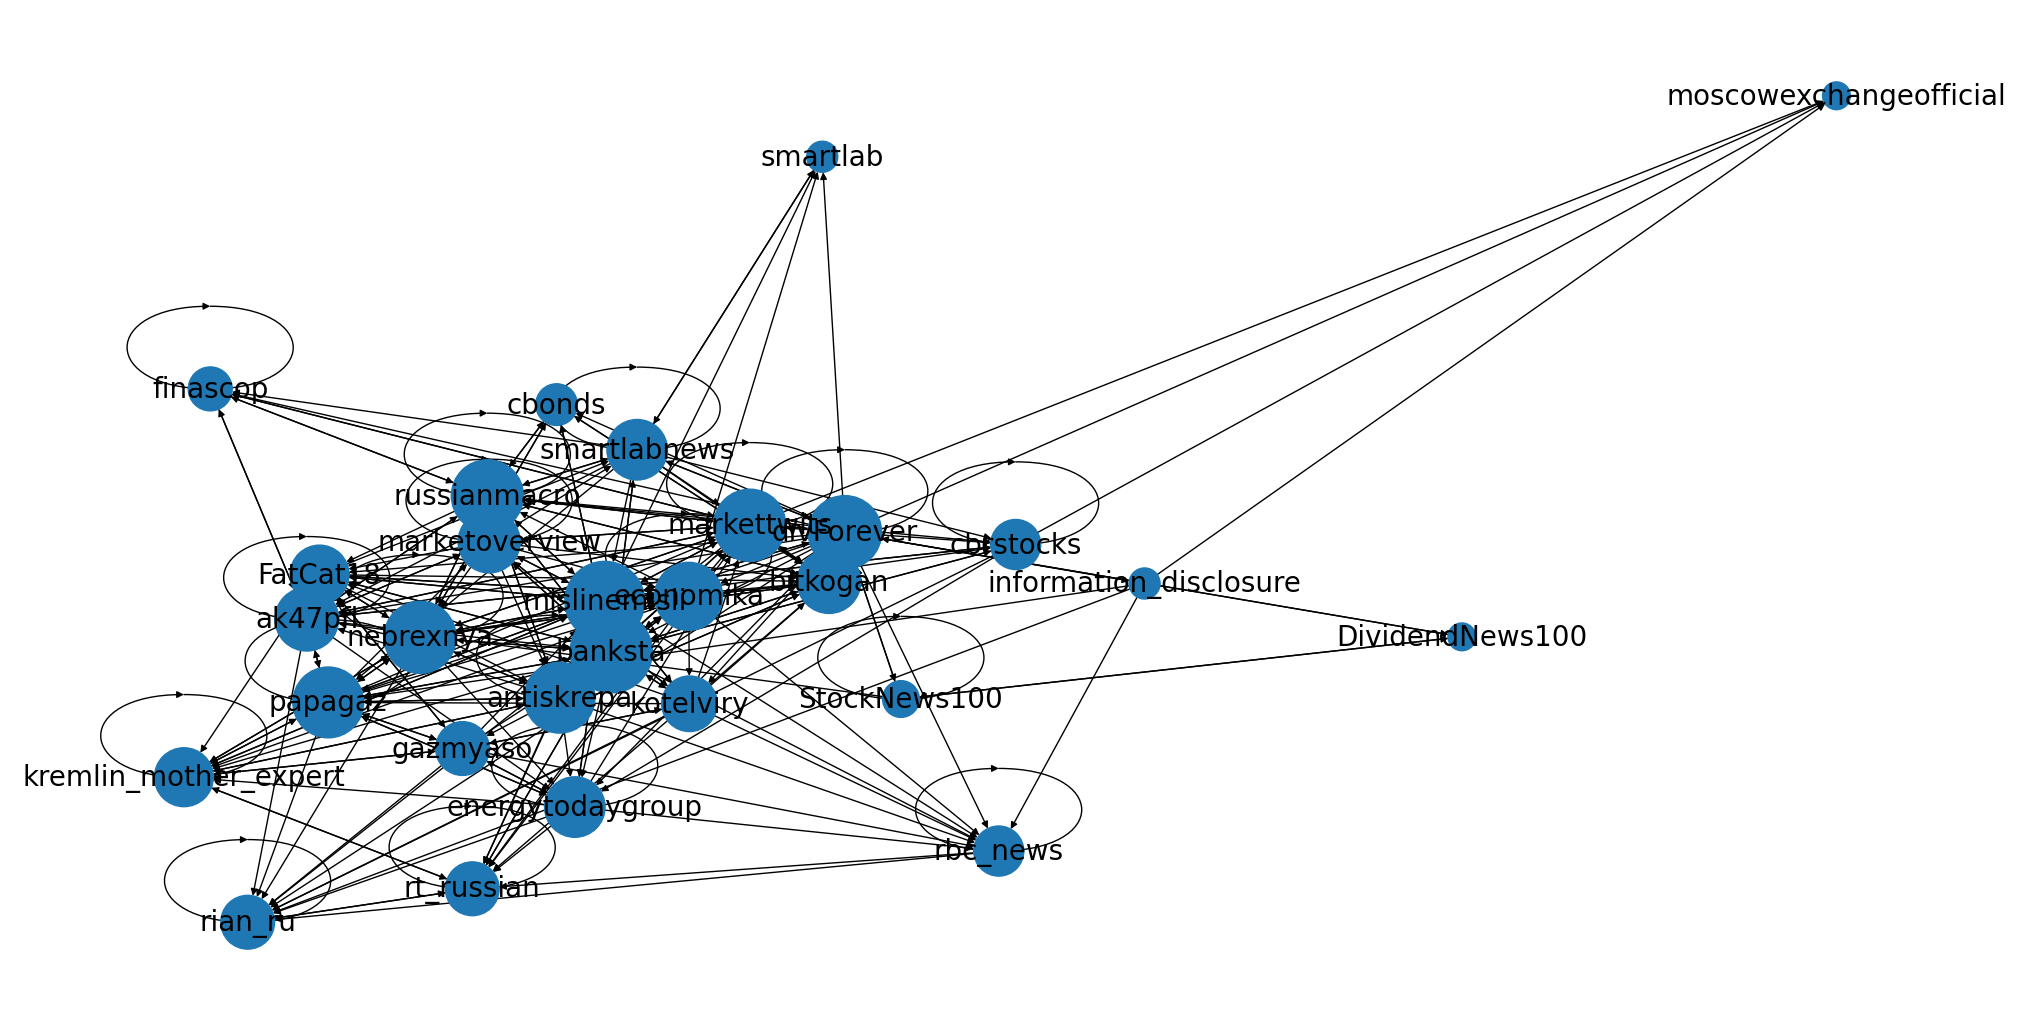

In [39]:
plt.figure(figsize = (20, 10))
pos = nx.spring_layout(g, scale=20, k=3/np.sqrt(g.order()))
d = dict(g.degree)
nx.draw(g, pos, with_labels = True, font_size = 20, node_size=[d[k]*100 for k in d])
plt.show()

### Распределение новостей во времени по компаниям

In [2]:
companies = {
    'ALRS': 'alrosa-ao', 'AFLT': 'aeroflot', 'VTBR': 'vtb', 'GAZP' : 'gazprom', 'GMKN': 'nornickel-gmk', 'LSRG': 'lsr', 
    'DSKY': 'detsky-mir', 'IRAO': 'inter-rao-ao', 'LKOH': 'lukoil', 'MAGN': 'mmk', 'MOEX': 'moscowexchange', 'CBOM': 'oao-mkb-ao', 
    'MTSS': 'mts', 'ROSN': 'rosneft', 'NLMK': 'nlmk-ao', 'NVTK': 'novatek', 'PIKK': 'pik', 
    'PLZL': 'polus-zoloto', 'RTKM': 'rostelecom', 'RUAL': 'united-company-rusal-plc', 'HYDR': 'rusgidro', 'SBER': 'sberbank', 'CHMF': 'severstal-ao', 
    'AFKS': 'afk-sistema', 'SNGS': 'surgut', 'TATN': 'tatneft-3', 'TCSG': 'gdr-tcs-group-holding-ord-shs_tcsg', 'TRNFP': 'transneft-pref', 
    'POGR': 'petropavlovsk-plc_pogr', 'PHOR': 'phosagro-ao', 'FEES': 'fsk-ees', 'HHRU': 'adr-headhunter-group-ord-shs_hhru', 'YNDX': 'pllc-yandex-n-v'}

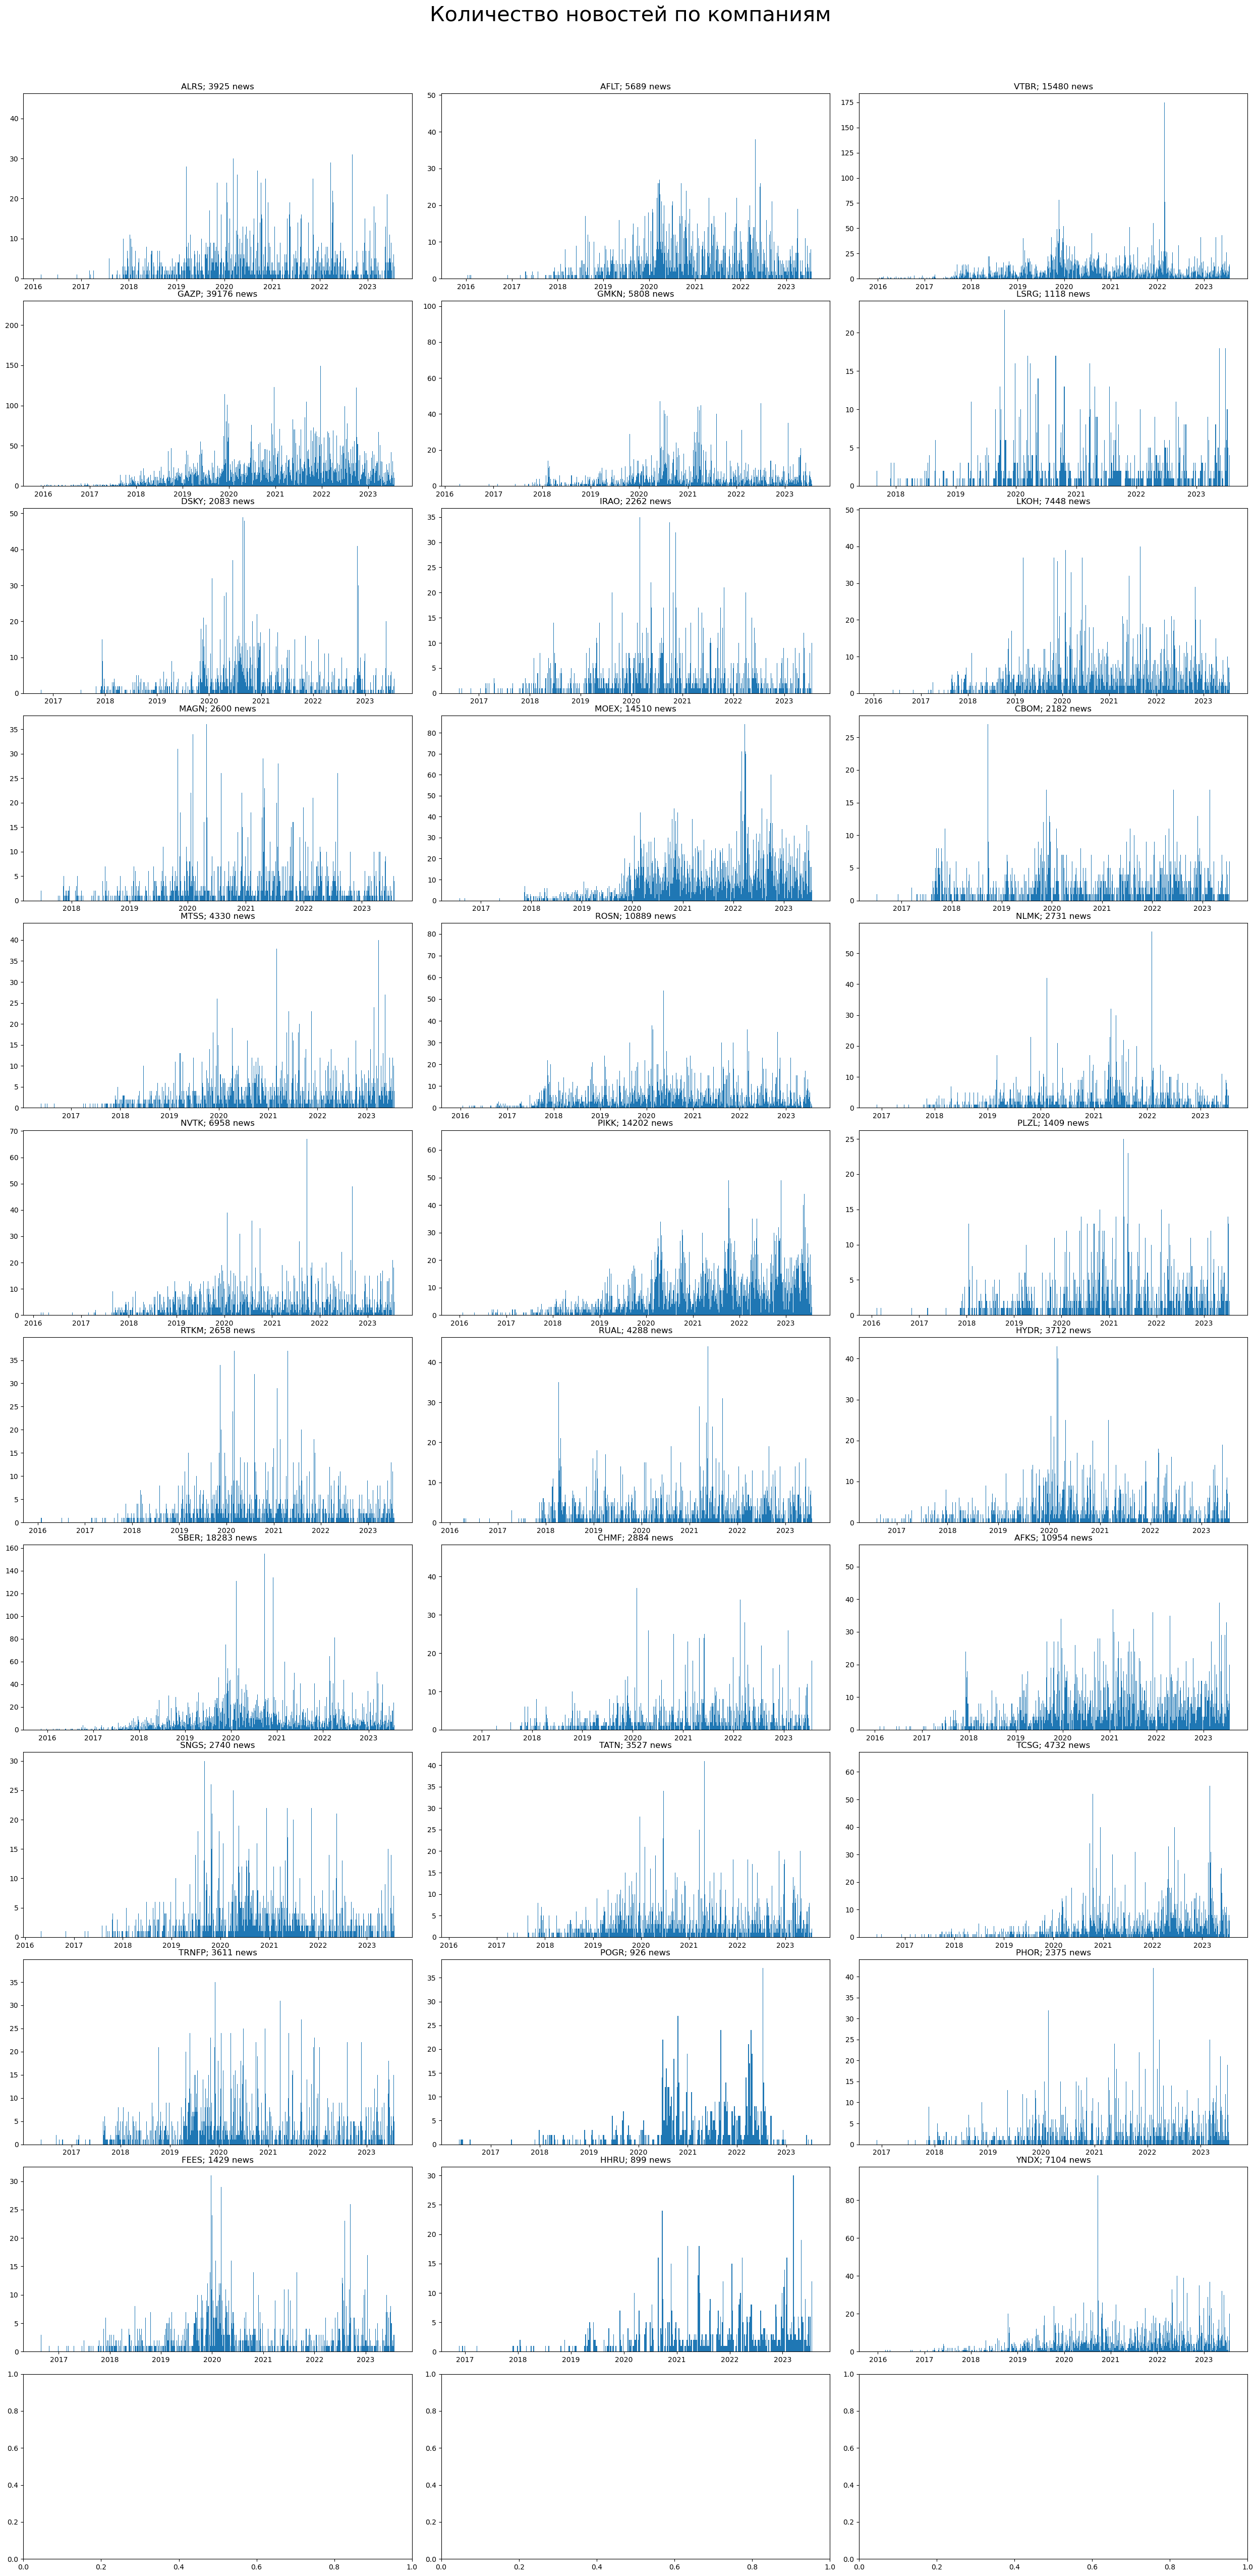

In [3]:
from EDA_utils import plot_company_news_hist_tg
plot_company_news_hist_tg(companies)

In [3]:
# sectors = ['finance', 'gold', 'ferrous_metallurgy', 'oil_gas', 'non_ferrous_metallurgy',
#           'electrical networks', 'telecom', 'it', 'real_estate']

In [1]:
# from EDA_utils import plot_sector_news_hist
# plot_sector_news_hist(roots, sectors)

In [2]:
# from EDA_utils import plot_sector_news_hist_tg
# plot_sector_news_hist_tg(sectors)